In [1]:
import torch
import numpy as np
import pandas as pd
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network
from target import NN_bernoulli
from utils import plot_digit_samples, get_samples
from args import get_args

from data import Dataset

In [2]:

general_name = 'data_mnist_K_2_N_1_fixtransition_False_amortize_False_learnreverse_True_vanillaepoches_0_hoffmanlike_True_learnaccept_False'
NUM_EVALS = 3

In [3]:
args = get_args()

args.device = "cuda:1"
args.std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=args.torchType, device=args.device),
                                            scale=torch.tensor(1., dtype=args.torchType, device=args.device))
dataset = Dataset(args, args.device)

In [4]:
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        args[key] = int(value)
    elif value in ['True', 'False']:
        args[key] = True if value=='True' else False
    else:
        args[key] = value

In [5]:
#### First, we load train models and fix their params
decoder = torch.load('./models/mnist/best_decoder_{}.pt'.format(general_name), map_location=args.device)
decoder.eval()
for p in decoder.parameters():
    p.requires_grad_(False)
target = NN_bernoulli(args, decoder, args.device)

In [6]:
encoder = torch.load('./models/mnist/best_encoder_{}.pt'.format(general_name), map_location=args.device)
encoder.eval()
for p in encoder.parameters():
    p.requires_grad_(False)

In [7]:
transitions = torch.load('./models/mnist/best_transitions_{}.pt'.format(general_name), map_location=args.device)
transitions.eval()
if args.amortize:
    transitions.device = args.device
else:
    for k in range(args.K):
        transitions[k].device = args.device
for p in transitions.parameters():
    p.requires_grad_(False)

In [8]:
if args.learnable_reverse:
    reverse_kernel = torch.load('./models/mnist/best_reverse_{}.pt'.format(general_name), map_location=args.device)
    reverse_kernel.eval()
    reverse_kernel.device = args.device
    for p in reverse_kernel.parameters():
        p.requires_grad_(False)

In [9]:
if args.numnfpriors:
    priorflow = torch.load('./models/mnist/best_priorflow_{}.pt'.format(general_name), map_location=args.device)
    priorflow.eval()
    priorflow.device = args.device
    for p in priorflow.parameters():
        p.requires_grad_(False)

Saved samples to ./pics/mnist_epoch_-1_K_2_N_1_amortize_False.png


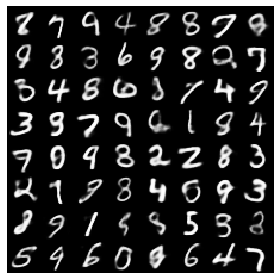

In [7]:
random_code = torch.distributions.Normal(loc=torch.tensor(0., device=args.device),
                                                                 scale=torch.tensor(1., device=args.device)).sample((64, args.z_dim))
rand_code = random_code
# for pflow in priorflow:
#     rand_code = pflow._inverse(rand_code)
plot_digit_samples(samples=get_samples(target.decoder,
                                       rand_code),
                   args=args, epoch=-1)

### NLL estimation using importance sampling with inference part from training

In [10]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo

In [11]:
# def compute_marginal_q(z_final, K, x, mu=None, sigma=None):
#     aux_matrix = torch.empty((z_final.shape[0], 3**K), device=device, dtype=torchType)
#     directions_all = np.array(list(itertools.product(np.arange(3) - 1, repeat=K)))
#     cond_distr = torch.distributions.Normal(loc=mu, scale=sigma)
#     for d_num, directions in enumerate(directions_all):
#         sum_log_alpha = torch.zeros(z_final.shape[0], dtype=torchType, device=device) # for grad log alpha accumulation
#         sum_log_jacobian = torch.zeros(z_final.shape[0], dtype=torchType, device=device) # for log_jacobian accumulation
#         z = z_final
#         for k in range(K)[::-1]:
#             if directions[k]==1.:
#                 current_log_alphas = transitions[k].get_log_alpha_1(z_old=z, x=x)
#             elif directions[k]==-1:
#                 current_log_alphas = transitions[k].get_log_alpha_m1(z_old=z, x=x)
#             else:
#                 current_log_alphas = transitions[k].get_log_alpha_0(z_old=z, x=x)
#             z_upd, log_jac = transitions[k].make_transition(z_old=z, x=x, directions=directions[k] * torch.ones(z.shape[0], dtype=torchType, device=device),
#                                                             k=cond_vectors[k]) # sample new positions and log_jacobians of transformations
#             sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
#             sum_log_alpha = sum_log_alpha + current_log_alphas
#             z = z_upd
#         log_q_joint = cond_distr.log_prob(z).sum(1) + sum_log_jacobian + sum_log_alpha
#         aux_matrix[:, d_num] = log_q_joint
#     loq_q_marginal = torch.logsumexp(aux_matrix, dim=1)
#     return loq_q_marginal

In [12]:
means = []
stds = []
for _ in range(NUM_EVALS):
    nll = []
    for test_batch in tqdm(dataset.next_test_batch(), total=dataset.test.shape[0] // dataset.test_batch_size):
        mu, sigma = encoder(test_batch)

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u

        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None

        for k in range(args.K):
    #         pdb.set_trace()
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=test_batch,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=test_batch,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        nll_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=test_batch, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)

        nll.append(nll_current.cpu().detach().numpy())
    means.append(np.mean(nll))

100%|██████████| 1000/1000 [1:38:07<00:00,  5.89s/it]


In [13]:
print(means)

[-94.34207, -94.260765, -94.39794]


In [14]:
print('Mean', np.mean(means))
print('Std', np.std(means))

Mean -94.333595
Std 0.056322087


In [15]:
d = {}
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        d[key] = [int(value)]
    elif value in ['True', 'False']:
        d[key] = [True if value=='True' else False]
    else:
        d[key] = [value]
d['Mean'] = [np.mean(means)]
d['std'] = [np.std(means)]
d['eval_method'] = ['IS_with_same_inference_part']

In [16]:
d

{'data': ['mnist'],
 'K': [2],
 'N': [2],
 'fixtransition': [False],
 'amortize': [False],
 'learnreverse': [True],
 'vanillaepoches': [0],
 'hoffmanlike': [True],
 'separateparams': [True],
 'usebatchnorm': [True],
 'decoder': ['deconv'],
 'Mean': [-94.333595],
 'std': [0.056322087],
 'eval_method': ['IS_with_same_inference_part']}

In [17]:
df_cur = pd.DataFrame(data=d, columns=d.keys())
file_name = './nll_results.csv'
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    df_cur = pd.concat([df, df_cur])
df_cur.to_csv(file_name, index=False)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


### NLL estimation using IS and separately trained encoder

In [8]:
from pyro.nn import AutoRegressiveNN, DenseNN
from pyro.distributions.transforms import NeuralAutoregressive
import torch.nn as nn

In [9]:
encoder_aux = Inf_network(args).to(args.device)
best_encoder_aux = Inf_network(args).to(args.device)
n_flows = 3

flows = []
for i in range(n_flows):
    one_arn = AutoRegressiveNN(args.z_dim, [2 * args.z_dim], param_dims=[2 * args.z_dim] * 3).to(args.device)
    one_flows = NeuralAutoregressive(one_arn, hidden_units=64)
    flows.append(one_flows)
variational_flow = nn.ModuleList(flows)

best_flows = []
for i in range(n_flows):
    one_arn = AutoRegressiveNN(args.z_dim, [2 * args.z_dim], param_dims=[2 * args.z_dim] * 3).to(args.device)
    one_flows = NeuralAutoregressive(one_arn, hidden_units=64)
    best_flows.append(one_flows)
best_variational_flow = nn.ModuleList(best_flows)

params = list(encoder_aux.parameters()) + list(variational_flow.parameters())

optimizer_aux = torch.optim.Adam(params=params)

  0%|          | 0/1000 [00:00<?, ?it/s]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


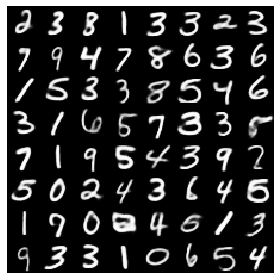

  0%|          | 1/1000 [00:12<3:20:55, 12.07s/it]

Current validation ELBO (epoch 0): -112.5941
Best validation ELBO  -112.5941


  1%|          | 10/1000 [02:00<3:19:57, 12.12s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


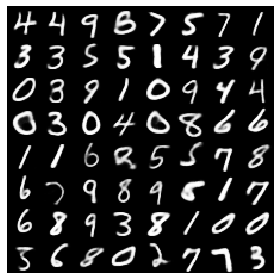

  1%|          | 11/1000 [02:13<3:20:13, 12.15s/it]

Current validation ELBO (epoch 10): -96.23295
Best validation ELBO  -96.23295


  2%|▏         | 20/1000 [04:02<3:18:23, 12.15s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


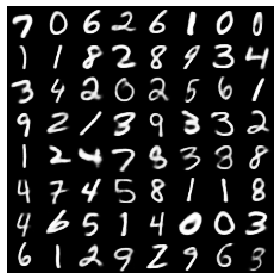

  2%|▏         | 21/1000 [04:14<3:18:33, 12.17s/it]

Current validation ELBO (epoch 20): -95.485886
Best validation ELBO  -95.23717


  3%|▎         | 30/1000 [06:04<3:16:47, 12.17s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


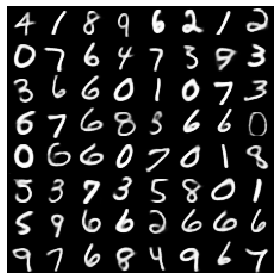

  3%|▎         | 31/1000 [06:16<3:17:01, 12.20s/it]

Current validation ELBO (epoch 30): -94.84399
Best validation ELBO  -94.75081


  4%|▍         | 40/1000 [08:06<3:14:48, 12.18s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


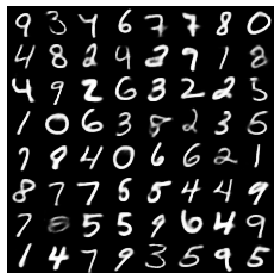

  4%|▍         | 41/1000 [08:18<3:14:50, 12.19s/it]

Current validation ELBO (epoch 40): -94.6859
Best validation ELBO  -94.622505


  5%|▌         | 50/1000 [10:07<3:12:43, 12.17s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


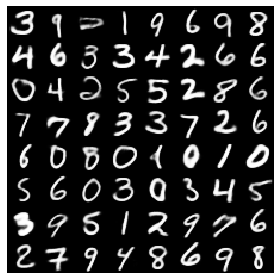

  5%|▌         | 51/1000 [10:20<3:12:48, 12.19s/it]

Current validation ELBO (epoch 50): -94.541794
Best validation ELBO  -94.28321


  6%|▌         | 60/1000 [12:09<3:10:57, 12.19s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


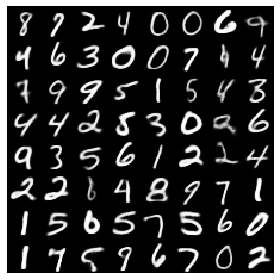

  6%|▌         | 61/1000 [12:21<3:11:00, 12.21s/it]

Current validation ELBO (epoch 60): -94.4123
Best validation ELBO  -94.25203


  7%|▋         | 70/1000 [14:11<3:08:46, 12.18s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


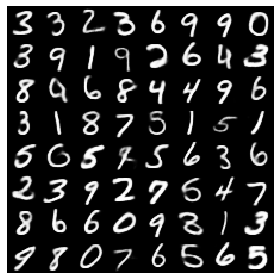

  7%|▋         | 71/1000 [14:23<3:08:47, 12.19s/it]

Current validation ELBO (epoch 70): -94.22121
Best validation ELBO  -94.04409


  8%|▊         | 80/1000 [16:13<3:06:52, 12.19s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


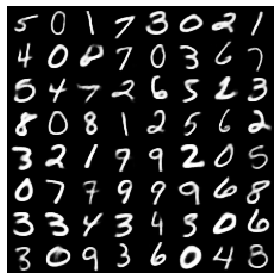

  8%|▊         | 81/1000 [16:25<3:06:53, 12.20s/it]

Current validation ELBO (epoch 80): -94.205734
Best validation ELBO  -93.99203


  9%|▉         | 90/1000 [18:15<3:04:43, 12.18s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


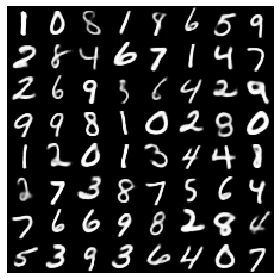

  9%|▉         | 91/1000 [18:27<3:04:47, 12.20s/it]

Current validation ELBO (epoch 90): -94.01215
Best validation ELBO  -93.86233


 10%|█         | 100/1000 [20:17<3:02:40, 12.18s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


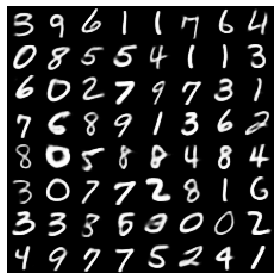

 10%|█         | 101/1000 [20:29<3:02:43, 12.20s/it]

Current validation ELBO (epoch 100): -94.17914
Best validation ELBO  -93.86233


 11%|█         | 110/1000 [22:19<3:00:38, 12.18s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


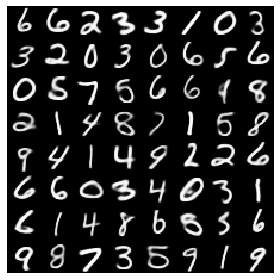

 11%|█         | 111/1000 [22:31<3:00:40, 12.19s/it]

Current validation ELBO (epoch 110): -93.94226
Best validation ELBO  -93.86233


 12%|█▏        | 120/1000 [24:20<2:58:35, 12.18s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


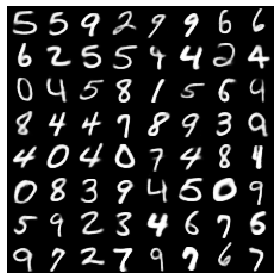

 12%|█▏        | 121/1000 [24:33<2:58:37, 12.19s/it]

Current validation ELBO (epoch 120): -93.92024
Best validation ELBO  -93.86023


 13%|█▎        | 130/1000 [26:22<2:56:41, 12.19s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


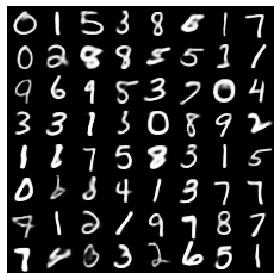

 13%|█▎        | 131/1000 [26:34<2:56:39, 12.20s/it]

Current validation ELBO (epoch 130): -94.11345
Best validation ELBO  -93.775696


 14%|█▍        | 140/1000 [28:24<2:54:53, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


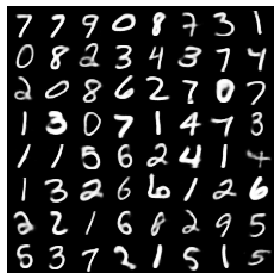

 14%|█▍        | 141/1000 [28:37<2:54:55, 12.22s/it]

Current validation ELBO (epoch 140): -94.01944
Best validation ELBO  -93.775696


 15%|█▌        | 150/1000 [30:26<2:52:36, 12.18s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


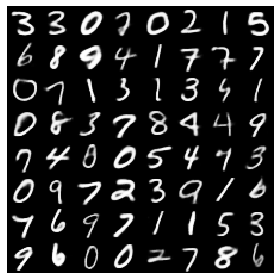

 15%|█▌        | 151/1000 [30:38<2:52:37, 12.20s/it]

Current validation ELBO (epoch 150): -93.968445
Best validation ELBO  -93.63811


 16%|█▌        | 160/1000 [32:28<2:50:31, 12.18s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


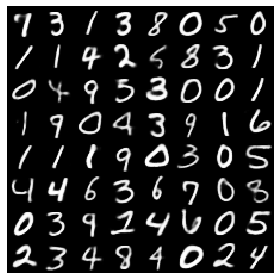

 16%|█▌        | 161/1000 [32:40<2:50:32, 12.20s/it]

Current validation ELBO (epoch 160): -93.79372
Best validation ELBO  -93.63811


 17%|█▋        | 170/1000 [34:30<2:48:38, 12.19s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


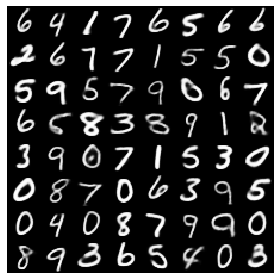

 17%|█▋        | 171/1000 [34:42<2:48:40, 12.21s/it]

Current validation ELBO (epoch 170): -93.65575
Best validation ELBO  -93.63811


 18%|█▊        | 180/1000 [36:32<2:46:48, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


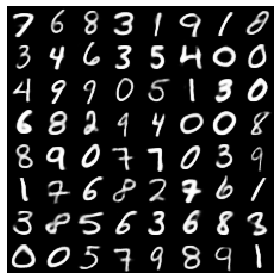

 18%|█▊        | 181/1000 [36:44<2:46:57, 12.23s/it]

Current validation ELBO (epoch 180): -93.75514
Best validation ELBO  -93.63811


 19%|█▉        | 190/1000 [38:34<2:44:44, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


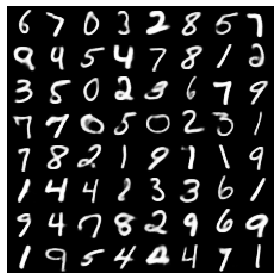

 19%|█▉        | 191/1000 [38:46<2:44:53, 12.23s/it]

Current validation ELBO (epoch 190): -93.99887
Best validation ELBO  -93.63811


 20%|██        | 200/1000 [40:36<2:42:34, 12.19s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


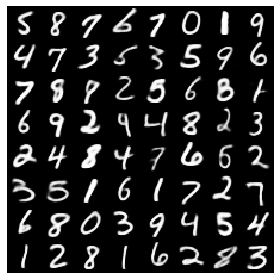

 20%|██        | 201/1000 [40:48<2:42:34, 12.21s/it]

Current validation ELBO (epoch 200): -93.77444
Best validation ELBO  -93.63811


 21%|██        | 210/1000 [42:38<2:40:39, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


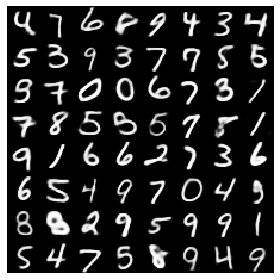

 21%|██        | 211/1000 [42:51<2:40:45, 12.23s/it]

Current validation ELBO (epoch 210): -93.83449
Best validation ELBO  -93.63023


 22%|██▏       | 220/1000 [44:40<2:38:38, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


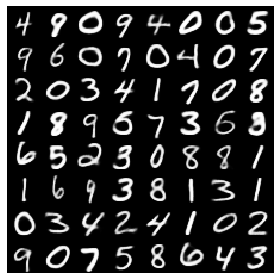

 22%|██▏       | 221/1000 [44:53<2:38:41, 12.22s/it]

Current validation ELBO (epoch 220): -93.80235
Best validation ELBO  -93.63023


 23%|██▎       | 230/1000 [46:42<2:36:36, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


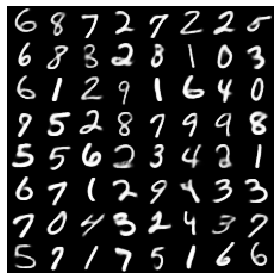

 23%|██▎       | 231/1000 [46:55<2:36:41, 12.23s/it]

Current validation ELBO (epoch 230): -93.55454
Best validation ELBO  -93.55454


 24%|██▍       | 240/1000 [48:44<2:34:33, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


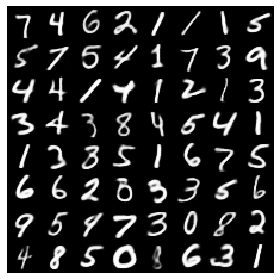

 24%|██▍       | 241/1000 [48:57<2:34:35, 12.22s/it]

Current validation ELBO (epoch 240): -94.20059
Best validation ELBO  -93.55454


 25%|██▌       | 250/1000 [50:47<2:32:25, 12.19s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


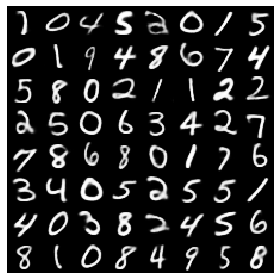

 25%|██▌       | 251/1000 [50:59<2:32:29, 12.22s/it]

Current validation ELBO (epoch 250): -93.55495
Best validation ELBO  -93.55454


 26%|██▌       | 260/1000 [52:49<2:30:32, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


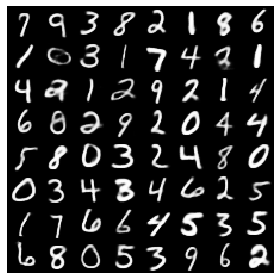

 26%|██▌       | 261/1000 [53:01<2:30:32, 12.22s/it]

Current validation ELBO (epoch 260): -93.52504
Best validation ELBO  -93.52504


 27%|██▋       | 270/1000 [54:51<2:28:26, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


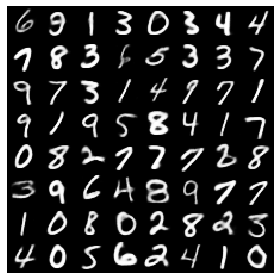

 27%|██▋       | 271/1000 [55:03<2:28:34, 12.23s/it]

Current validation ELBO (epoch 270): -93.78797
Best validation ELBO  -93.50574


 28%|██▊       | 280/1000 [56:53<2:26:29, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


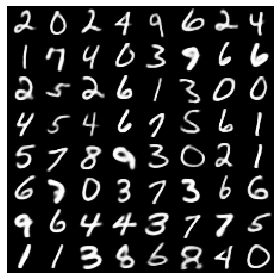

 28%|██▊       | 281/1000 [57:05<2:26:36, 12.23s/it]

Current validation ELBO (epoch 280): -93.57216
Best validation ELBO  -93.50574


 29%|██▉       | 290/1000 [58:55<2:24:29, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


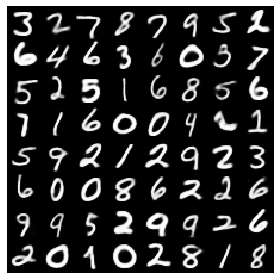

 29%|██▉       | 291/1000 [59:07<2:24:26, 12.22s/it]

Current validation ELBO (epoch 290): -93.62119
Best validation ELBO  -93.50574


 30%|███       | 300/1000 [1:00:57<2:22:22, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


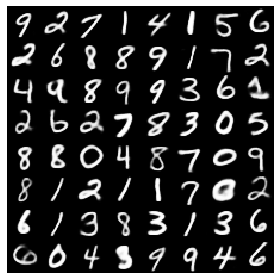

 30%|███       | 301/1000 [1:01:09<2:22:24, 12.22s/it]

Current validation ELBO (epoch 300): -93.57209
Best validation ELBO  -93.499016


 31%|███       | 310/1000 [1:02:59<2:20:20, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


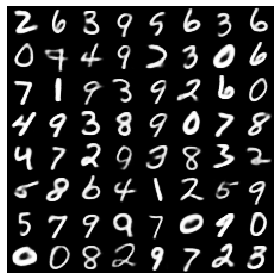

 31%|███       | 311/1000 [1:03:12<2:20:19, 12.22s/it]

Current validation ELBO (epoch 310): -93.52066
Best validation ELBO  -93.499016


 32%|███▏      | 320/1000 [1:05:02<2:19:31, 12.31s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


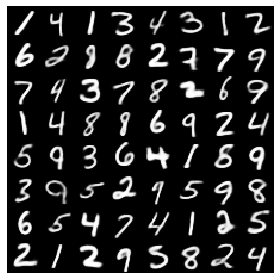

 32%|███▏      | 321/1000 [1:05:14<2:19:04, 12.29s/it]

Current validation ELBO (epoch 320): -93.64747
Best validation ELBO  -93.43821


 33%|███▎      | 330/1000 [1:07:05<2:17:30, 12.31s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


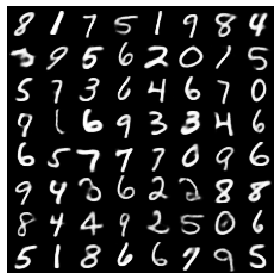

 33%|███▎      | 331/1000 [1:07:17<2:17:13, 12.31s/it]

Current validation ELBO (epoch 330): -93.67897
Best validation ELBO  -93.433556


 34%|███▍      | 340/1000 [1:09:07<2:14:16, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


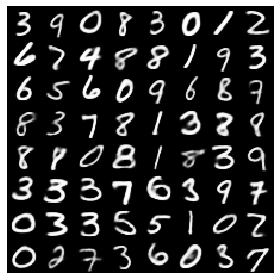

 34%|███▍      | 341/1000 [1:09:19<2:14:13, 12.22s/it]

Current validation ELBO (epoch 340): -93.6054
Best validation ELBO  -93.432014


 35%|███▌      | 350/1000 [1:11:09<2:12:10, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


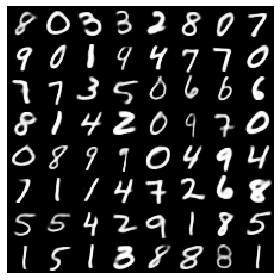

 35%|███▌      | 351/1000 [1:11:21<2:12:20, 12.24s/it]

Current validation ELBO (epoch 350): -94.07344
Best validation ELBO  -93.432014


 36%|███▌      | 360/1000 [1:13:11<2:10:03, 12.19s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


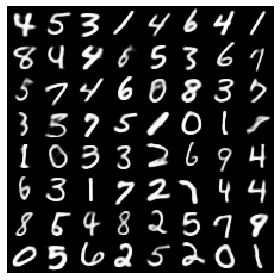

 36%|███▌      | 361/1000 [1:13:23<2:10:01, 12.21s/it]

Current validation ELBO (epoch 360): -93.6762
Best validation ELBO  -93.4002


 37%|███▋      | 370/1000 [1:15:13<2:08:08, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


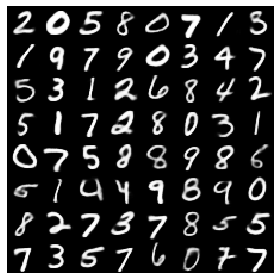

 37%|███▋      | 371/1000 [1:15:25<2:08:06, 12.22s/it]

Current validation ELBO (epoch 370): -93.39812
Best validation ELBO  -93.39812


 38%|███▊      | 380/1000 [1:17:15<2:06:12, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


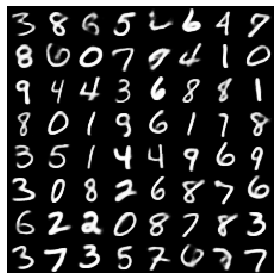

 38%|███▊      | 381/1000 [1:17:28<2:06:09, 12.23s/it]

Current validation ELBO (epoch 380): -93.61941
Best validation ELBO  -93.39812


 39%|███▉      | 390/1000 [1:19:17<2:04:04, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


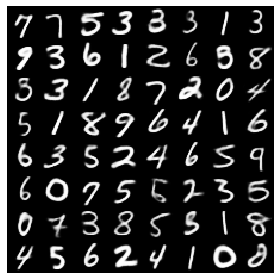

 39%|███▉      | 391/1000 [1:19:30<2:04:01, 12.22s/it]

Current validation ELBO (epoch 390): -93.63218
Best validation ELBO  -93.39812


 40%|████      | 400/1000 [1:21:19<2:01:58, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


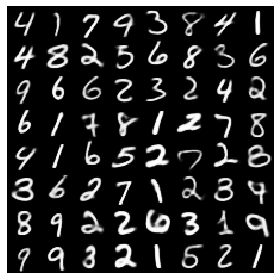

 40%|████      | 401/1000 [1:21:32<2:01:57, 12.22s/it]

Current validation ELBO (epoch 400): -93.63702
Best validation ELBO  -93.39812


 41%|████      | 410/1000 [1:23:22<2:00:04, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


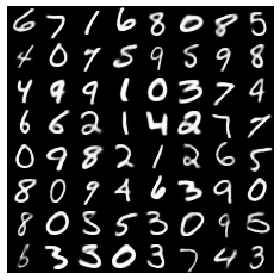

 41%|████      | 411/1000 [1:23:34<2:00:02, 12.23s/it]

Current validation ELBO (epoch 410): -93.58387
Best validation ELBO  -93.39812


 42%|████▏     | 420/1000 [1:25:24<1:58:03, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


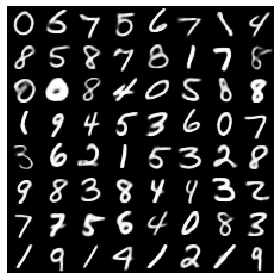

 42%|████▏     | 421/1000 [1:25:36<1:58:04, 12.24s/it]

Current validation ELBO (epoch 420): -93.63411
Best validation ELBO  -93.39812


 43%|████▎     | 430/1000 [1:27:26<1:55:57, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


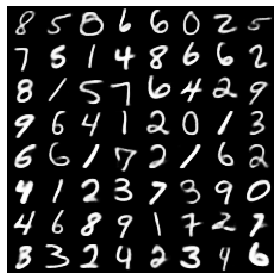

 43%|████▎     | 431/1000 [1:27:38<1:55:53, 12.22s/it]

Current validation ELBO (epoch 430): -94.02793
Best validation ELBO  -93.39812


 44%|████▍     | 440/1000 [1:29:28<1:53:53, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


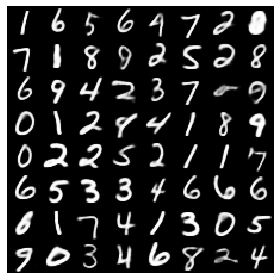

 44%|████▍     | 441/1000 [1:29:40<1:53:53, 12.22s/it]

Current validation ELBO (epoch 440): -93.54263
Best validation ELBO  -93.39812


 45%|████▌     | 450/1000 [1:31:30<1:51:50, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


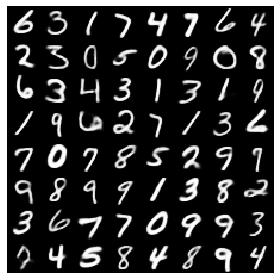

 45%|████▌     | 451/1000 [1:31:42<1:51:51, 12.23s/it]

Current validation ELBO (epoch 450): -93.66719
Best validation ELBO  -93.383194


 46%|████▌     | 460/1000 [1:33:32<1:49:49, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


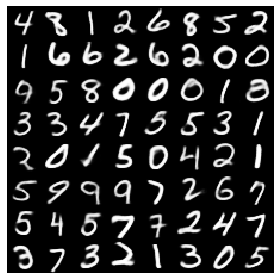

 46%|████▌     | 461/1000 [1:33:44<1:49:46, 12.22s/it]

Current validation ELBO (epoch 460): -93.47097
Best validation ELBO  -93.36065


 47%|████▋     | 470/1000 [1:35:34<1:47:46, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


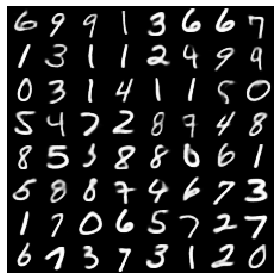

 47%|████▋     | 471/1000 [1:35:46<1:47:45, 12.22s/it]

Current validation ELBO (epoch 470): -93.408554
Best validation ELBO  -93.36065


 48%|████▊     | 480/1000 [1:37:36<1:45:42, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


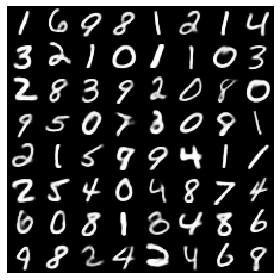

 48%|████▊     | 481/1000 [1:37:48<1:45:38, 12.21s/it]

Current validation ELBO (epoch 480): -93.60345
Best validation ELBO  -93.36065


 49%|████▉     | 490/1000 [1:39:38<1:43:47, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


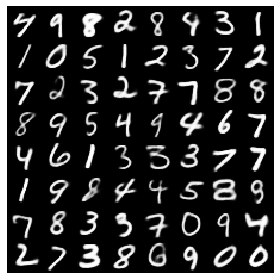

 49%|████▉     | 491/1000 [1:39:51<1:43:44, 12.23s/it]

Current validation ELBO (epoch 490): -93.58358
Best validation ELBO  -93.36065


 50%|█████     | 500/1000 [1:41:40<1:41:47, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


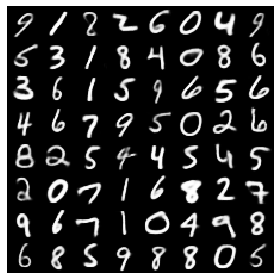

 50%|█████     | 501/1000 [1:41:53<1:41:43, 12.23s/it]

Current validation ELBO (epoch 500): -93.60755
Best validation ELBO  -93.36065


 51%|█████     | 510/1000 [1:43:43<1:39:42, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


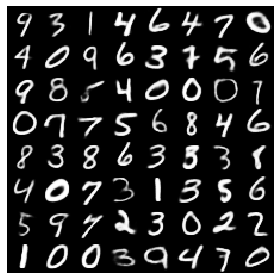

 51%|█████     | 511/1000 [1:43:55<1:39:44, 12.24s/it]

Current validation ELBO (epoch 510): -93.52214
Best validation ELBO  -93.36065


 52%|█████▏    | 520/1000 [1:45:45<1:37:38, 12.21s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


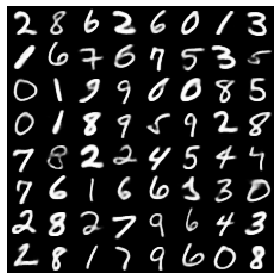

 52%|█████▏    | 521/1000 [1:45:57<1:37:34, 12.22s/it]

Current validation ELBO (epoch 520): -93.72002
Best validation ELBO  -93.36065


 53%|█████▎    | 530/1000 [1:47:47<1:35:31, 12.20s/it]

Saved samples to ./pics/mnist_epoch_-2_K_2_N_1_amortize_False.png


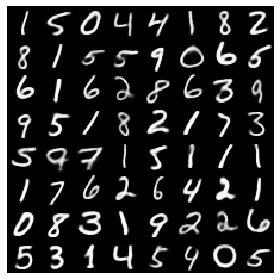

 53%|█████▎    | 531/1000 [1:47:59<1:35:27, 12.21s/it]

Current validation ELBO (epoch 530): -93.559296
Best validation ELBO  -93.36065


 53%|█████▎    | 531/1000 [1:48:11<1:35:33, 12.23s/it]

Early stopping on epoch 531 (effectively trained for 456 epoches)


In [10]:
##### First, we need to train it #####
best_elbo = -float('inf')
current_tolerance = 0

iterator = tqdm(range(1000))
for ep in iterator:
    for train_batch in dataset.next_train_batch():
        mu, sigma, _ = encoder_aux(train_batch)
        u = args.std_normal.sample(mu.shape)
        z = mu + u * sigma
        z_prev = z
        sum_log_jac = 0.
        for flow in variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=train_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        elbo = torch.mean(log_p - log_q)
        (-elbo).backward()
        optimizer_aux.step()
        optimizer_aux.zero_grad()
    if ep % 10 == 0:
        plot_digit_samples(samples=get_samples(target.decoder,
                                       z_new[:64]),
                   args=args, epoch=-2)
    ##### Validation #####
    elbo_list = []
    for val_batch in dataset.next_val_batch():
        mu, sigma, _ = encoder_aux(val_batch)
        u = args.std_normal.sample(mu.shape)
        z = mu + u * sigma
        z_prev = z
        sum_log_jac = 0.
        for flow in variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=val_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        elbo = torch.mean(log_p - log_q).cpu().detach().numpy()
        elbo_list.append(elbo)
    current_elbo_val = np.mean(elbo_list)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        best_encoder_aux.load_state_dict(encoder_aux.state_dict())
        best_variational_flow.load_state_dict(variational_flow.state_dict())
    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            iterator.close()
            break
    if ep % 10 == 0:
        print('Current validation ELBO (epoch {}):'.format(ep), current_elbo_val)
        print('Best validation ELBO ', best_elbo)

In [11]:
for p in best_encoder_aux.parameters():
    p.requires_grad_(False)
for p in best_variational_flow.parameters():
    p.requires_grad_(False)  

In [12]:
torch.save(best_encoder_aux, './eval_models/best_encoder_aux.pt')
torch.save(best_variational_flow, './eval_models/best_variational_flow.pt')

In [15]:
import gc
del encoder_aux
del variational_flow
del current_elbo_val
del params
del optimizer_aux
del elbo
del elbo_list
del z
del log_p
del log_q
del mu
del sigma
# del encoder
# del transitions
# del reverse_kernel
del sum_log_jac
gc.collect()
torch.cuda.empty_cache()

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [16]:
best_encoder_aux = torch.load('./eval_models/best_encoder_aux.pt')

In [17]:
best_variational_flow = torch.load('./eval_models/best_variational_flow.pt')

In [18]:
means = []
stds = []
for _ in range(NUM_EVALS):
    nll = []
    for test_batch in tqdm(dataset.next_test_batch(), total=dataset.test.shape[0] // dataset.test_batch_size):
        mu, sigma, _ = best_encoder_aux(test_batch)
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u

        z_prev = z
        sum_log_jac = 0.
        for flow in best_variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=test_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        nll_current = torch.mean(log_p - log_q)
        nll.append(nll_current.cpu().detach().numpy())
    means.append(np.mean(nll))

100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


In [19]:
d = {}
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        d[key] = [int(value)]
    elif value in ['True', 'False']:
        d[key] = [True if value=='True' else False]
    else:
        d[key] = [value]
d['Mean'] = [np.mean(means)]
d['std'] = [np.std(means)]
d['eval_method'] = ['IS_with_separately_trained_inference_part']

In [20]:
d

{'data': ['mnist'],
 'K': [2],
 'N': [1],
 'fixtransition': [False],
 'amortize': [False],
 'learnreverse': [True],
 'vanillaepoches': [0],
 'hoffmanlike': [True],
 'learnaccept': [False],
 'Mean': [-90.80948],
 'std': [0.016202813],
 'eval_method': ['IS_with_separately_trained_inference_part']}

In [21]:
df_cur = pd.DataFrame(data=d, columns=d.keys())
file_name = './nll_results.csv'
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    df_cur = pd.concat([df, df_cur])
df_cur.to_csv(file_name, index=False)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """
